In [1]:
using POMDPs, QuickPOMDPs, POMDPModelTools, POMDPPolicies, Parameters, Random, Plots, LinearAlgebra, Serialization
using POMDPTools, BasicPOMCP, GridInterpolations, POMCPOW, POMDPModels, Combinatorics, Dates, CSV, ParticleFilters, StatsBase

## Parameters

In [2]:
beta_vals = [0.01, 1.0]
args = [3 3 0.9 6 6 2 1000 5003]
;

## Create POMDP

In [3]:
@with_kw struct MyParameters
    N::Int = convert(Int64, args[1])         # size of item set
    K::Int = convert(Int64, args[2])         # size of arm set
    M::Int = length(beta_vals)               # size of beta set
    y::Float64 = args[3]                     # discount factor
    umax::Real = 10                          # max utility
    u_grain::Int = convert(Int64, args[4])   # granularity of utility approximation
    d_grain::Int = convert(Int64, args[5])   # granularity of arm distribution approximation
    beta::Array{Float64} = beta_vals         # teacher beta values
    exp_iters::Int = convert(Int64, args[6]) # number of rollouts to run
    exp_steps::Int = convert(Int64, args[7]) # number of timesteps per rollout
    s_index::Int = convert(Int64, args[8])   # index of true state
end

MyParameters

In [4]:
params = MyParameters()

struct State
    u::Array{Float64}         # list of N utility values for N items
    d::Array{Array{Float64}}  # list of K arm distributions, each assigning probabilities to N items
    b::Array{Float64}         # list of M beta values
end

# space of utility functions
umin = 0
grid_coor = fill(range(umin, params.umax, length=params.u_grain), params.N)
U = RectangleGrid(grid_coor...)

@assert length(U[1]) == params.N
println("generated " * string(length(U)) * " utilities (each length " * string(length(U[1])) * " items)")

function generate_probability_distributions(N::Int, coor::Array{Float64}, S::Float64=1.0)
    if S == 0
        return [[0.0 for _ in 1:N]]
    end
    if N == 1
        return [[float(S)]]
    end
    out = []
    range = coor[1:findall(x -> isapprox(x, S, atol=1e-15), coor)[1]]
    for k in range
        subsolution = generate_probability_distributions(N - 1, coor, S - k)
        for lst in subsolution
            if typeof(lst[1]) != Float64
                println("ERROR: lst " * string(lst) * " has type " * string(typeof(lst[1])) * ". Must be Float64.")
            end
            prepend!(lst, float(k))
        end
        out = vcat(out, subsolution)
    end
    return out
end

# space of arm distributions
coor = collect(range(0.0, 1.0, length=params.d_grain))
simplex_list = generate_probability_distributions(params.N, coor)
D_tuples = vec(collect(Base.product(fill(simplex_list, params.K)...)))
D = [collect(d) for d in D_tuples]

@assert length(D[1]) == params.K
@assert length(D[1][1]) == params.N
println("generated " * string(length(D)) * " arm distribution sets (each shape " * string(length(D[1])) * " arms x " * string(length(D[1][1])) * " items)")

# beta values
B = [params.beta]

# each beta value set must be length M
@assert length(B[1]) == params.M
println("generated " * string(length(B)) * " beta value sets (each length " * string(length(B[1])) * " teachers)")

# State space
S = [[State(u, d, b) for u in U, d in D, b in B]...,]

println("generated " * string(length(S)) * " states")

# Action space - actions are arm choices (K) or beta selections (M)
struct Action
    name::String      # valid names are {B,C} + index
    isBeta::Bool      # true if 'B' action, false if 'C' action
    index::Integer    # index of beta (if 'B' action) or arm choice (if 'C' action)
end

A = Array{Action}(undef, params.K + params.M)
for i in 1:params.K+params.M
    if i <= params.K
        A[i] = Action("C" * string(i), false, i)
    else
        A[i] = Action("B" * string(i - params.K), true, i - params.K)
    end
end
println("generated " * string(length(A)) * " actions")

# Transition function
function T(s::State, a::Action)
    return SparseCat([s], [1.0])    # categorical distribution
end
println("generated transition function")

# Reward function
function R(s::State, a::Action)
    # if beta selected, return 0
    if a.isBeta
        return 0
        # if arm pulled, return that arm's avg utility
    else
        utilities = s.u
        arm_dist = s.d[a.index]
        return dot(utilities, arm_dist)
    end
end
println("generated reward function")

# item space
I = 1:params.N

# preference space
struct Preference
    i0::Int    # first item to compare, in {1,2,...,N}
    i1::Int    # second item to compare, in {1,2,...,N}
    label::Int # feedback label, in {0,1}
end

P = [[Preference(i0, i1, label) for i0 in I, i1 in I, label in [0, 1]]...,]

# observation space
struct Observation
    isItem::Bool    # true if item returned, false otherwise
    i::Int          # item, if item returned
    p::Preference   # preference, if preference returned
end

invalid_i = -1
invalid_p = Preference(-1, -1, -1)
I_obs = [Observation(true, i, invalid_p) for i in I]
P_obs = [Observation(false, invalid_i, p) for p in P]
omega = union(I_obs, P_obs)

println("generated " * string(length(omega)) * " observations")

# unnormalized query profile (likelihood of querying 1,1; 2,1; 3,1; ... ; N,1; 1,2; 2,2; ... ; N,N)
Q = ones(params.N * params.N)

# preference probability (expected preference, or probability that preference=1)
function Pr(p::Preference, s::State, b::Float64)
    prob_pref_1 = exp(Float64(b) * s.u[p.i1]) / (exp(Float64(b) * s.u[p.i1]) + exp(Float64(b) * s.u[p.i0]))
    if p.label == 1
        return prob_pref_1
    else
        return 1.0 - prob_pref_1
    end
end

function O(s::State, a::Action, sp::State)
    # if B action, obs in P_obs
    if a.isBeta
        prob_of_pref = [Pr(o.p, s, s.b[a.index]) for o in P_obs]
        prob_of_query = vcat(Q, Q)   # doubled because each query appears once for each label

        # weight by querying profile to get dist
        dist = [prob_of_pref[i] * prob_of_query[i] for i in 1:length(prob_of_pref)]
        normalized_dist = dist / sum(dist)
        return SparseCat(P_obs, normalized_dist)
        # if C action, obs in I_obs
    else
        return SparseCat(I_obs, s.d[a.index])
    end
end

println("generated observation function")

# define POMDP
abstract type MyPOMDP <: POMDP{State,Action,Observation} end
pomdp = QuickPOMDP(MyPOMDP,
    states=S,
    actions=A,
    observations=omega,
    transition=T,
    observation=O,
    reward=R,
    discount=params.y,
    initialstate=S);

println("created POMDP")

generated 216 utilities (each length 3 items)
generated 9261 arm distribution sets (each shape 3 arms x 3 items)
generated 1 beta value sets (each length 2 teachers)
generated 2000376 states
generated 5 actions
generated transition function
generated reward function
generated 21 observations
generated observation function
created POMDP


## Generate Random Rollout

In [5]:
prior = Uniform(S)
true_state = S[params.s_index]
println("true state:\n"*string(true_state))

true state:
State([8.0, 10.0, 0.0], Array{Float64}[[0.0, 0.4, 0.6], [0.0, 0.2, 0.8], [0.0, 0.0, 1.0]], [0.01, 1.0])


In [16]:
steps = [x*1000 for x in 1:30]
runs = 100
;

In [17]:
obs = Dict{Int, Dict{Int, Array{Observation}}}()
act = Dict{Int, Dict{Int, Array{Action}}}()
for step in steps
    for run in 1:runs
        sim = RolloutSimulator(max_steps=step)
        a = Array{Action}(undef, step)
        o = Array{Observation}(undef, step)
        r = zeros(step)
        t = collect(1:step)

        policy = RandomPolicy(pomdp)
        i = 1
        for (st, ac, ob, re) in stepthrough(pomdp, policy, updater(policy), prior, true_state, "s,a,o,r", max_steps=step)
            a[i] = ac
            o[i] = ob
            r[i] = re
            i = i+1
        end
        
        if step ∉ keys(obs)
            obs[step] = Dict{Int, Array{Observation}}()
        end
        obs[step][run] = o
        if step ∉ keys(act)
            act[step] = Dict{Int, Array{Action}}()
        end
        act[step][run] = a
    end
end
        
        
        

## Infer Beta Values

In [18]:
# Which is the most numerous teacher query?
function get_query(o::Observation)
    if o.isItem
        return (-1,-1)
    end
    p = o.p
    i0 = p.i0
    i1 = p.i1
    if i0 < i1
        return (i0,i1)
    end
    return (i1,i0)
end

function infer_beta_vals(o, a)
    query_dict = Dict{Tuple{Int,Int}, Int}()
    for ob in o
        key = get_query(ob)
        if key[1] == -1
            continue
        end
        if key in keys(query_dict)
            query_dict[key] = query_dict[key]+1
        else
            query_dict[key] = 1
        end
    end

    max_key = -1
    max_val = -1
    for key in keys(query_dict)
        if query_dict[key] > max_val
            max_val = query_dict[key]
            max_key = key
        end
    end

#     println("most common query is "*string(max_key)*", which appears "*string(max_val)*" times")

    # Which preferences over the most common query come from which teacher?
    pref_dict = Dict{Action, Array{Preference}}()
    i0_pref = 0
    i1_pref = 0
    for i in 1:length(a)
        if !a[i].isBeta
            continue
        end
        q = get_query(o[i])
        if q != max_key
            continue
        end

        if o[i].p.i0 == max_key[1] && o[i].p.label == 0
            i0_pref = i0_pref+1
        elseif o[i].p.i1 == max_key[1] && o[i].p.label == 1
            i0_pref = i0_pref+1
        else
            i1_pref = i1_pref+1
        end

        if a[i] in keys(pref_dict)
            push!(pref_dict[a[i]], o[i].p)
        else
            pref_dict[a[i]] = [o[i].p]
        end
    end

    # Calc how often each teacher chooses better item
    P = Dict{Action, Float64}()
    epsilon = 0.001
    if i0_pref > i1_pref
        better_i = max_key[1]
    else
        better_i = max_key[2]
    end

    for teach in keys(pref_dict)
        better_i_pref = 0
        worse_i_pref = 0
        for p in pref_dict[teach]
            if p.i0 == better_i && p.label == 0
                better_i_pref = better_i_pref+1
            elseif p.i1 == better_i && p.label == 1
                better_i_pref = better_i_pref+1
            else
                worse_i_pref = worse_i_pref+1
            end
        end
        if worse_i_pref == 0
            println("WARNING: teacher "*string(teach.name)*" didn't ever choose worse item (approximating with epsilon)")
            P[teach] = epsilon/(better_i_pref+worse_i_pref)
        else
            P[teach] = worse_i_pref/(better_i_pref+worse_i_pref)
        end
    end
    betas = [log((1/P[key])-1) for key in keys(P)]
    return betas
end

infer_beta_vals (generic function with 1 method)

In [19]:
beta_vals

2-element Vector{Float64}:
 0.01
 1.0

In [20]:
betas = Dict{Int, Dict{Int, Array{Float64}}}()
for step in steps
    for run in 1:runs
        beta = infer_beta_vals(obs[step][run], act[step][run])
        
        if step ∉ keys(betas)
            betas[step] = Dict{Int, Array{Float64}}()
        end
        betas[step][run] = beta
        
        println(step, " steps, run ", run, ":\t", beta)
    end
end

1000 steps, run 1:	[10.736374936104498, -0.2451224580329851]
1000 steps, run 2:	[10.778935456339678, 0.42285685082003377]
1000 steps, run 3:	[10.714395546283317, 0.6664789334777839]
1000 steps, run 4:	[10.799555168721248, -0.039220713153281156]
1000 steps, run 5:	[10.645401087458245, 0.38776553100876354]
1000 steps, run 6:	[1.6916760106710724, -0.2876820724517809]
1000 steps, run 7:	[2.0794415416798357, 0.18924199963852853]
1000 steps, run 8:	[10.757881603870102, -0.24686007793152578]
1000 steps, run 9:	[2.0794415416798357, 0.4212134650763035]
1000 steps, run 10:	[10.81975828421028, -0.13353139262452263]
1000 steps, run 11:	[10.81975828421028, -0.15415067982725822]
1000 steps, run 12:	[10.878028324431728, 0.5232481437645479]
1000 steps, run 13:	[10.736374936104498, -0.4626235219481131]
1000 steps, run 14:	[10.799555168721248, 0.3513978868378886]
1000 steps, run 15:	[10.545315122572783, -0.33647223662121306]
1000 steps, run 16:	[3.9512437185814275, 0.0]
1000 steps, run 17:	[10.736374936

2000 steps, run 65:	[11.429532986406885, -0.040821994520255166]
2000 steps, run 66:	[2.0794415416798357, 0.4439313889359603]
2000 steps, run 67:	[11.326583838513384, -0.15415067982725822]
2000 steps, run 68:	[11.225230059096225, 0.32947920113024226]
2000 steps, run 69:	[11.418603796427618, -0.020202707317519466]
2000 steps, run 70:	[11.385080729759412, 0.3163373282121569]
2000 steps, run 71:	[1.889397938791971, -0.10318423623523088]
2000 steps, run 72:	[11.338560172992684, 0.19290366612449164]
2000 steps, run 73:	[11.338560172992684, 0.3331444465285385]
2000 steps, run 74:	[11.492712553519015, -0.10536051565782616]
2000 steps, run 75:	[11.407553838139561, 0.06595796779179758]
2000 steps, run 76:	[11.522865894784282, -0.22314355131421]
2000 steps, run 77:	[11.643944955408335, 0.27541197985996646]
2000 steps, run 78:	[1.5968591302272404, -0.30673026742247533]
2000 steps, run 79:	[2.5776883832389665, -0.30110509278392134]
2000 steps, run 80:	[1.5664205273504097, 0.0]
2000 steps, run 81:	[

3000 steps, run 53:	[1.8946168546677626, -0.03333642026759161]
3000 steps, run 54:	[1.8484548129046001, -0.12675170563914365]
3000 steps, run 55:	[11.904960795966668, 0.54654370636807]
3000 steps, run 56:	[11.931629220859403, 0.04652001563489312]
3000 steps, run 57:	[1.2437942985126076, -0.014388737452099556]
3000 steps, run 58:	[11.898181063016647, 0.07302513501488982]
3000 steps, run 59:	[11.870592916210601, 0.040821994520254985]
3000 steps, run 60:	[11.767559931375779, 0.2787134024690203]
3000 steps, run 61:	[1.7664416612437652, 0.015504186535965254]
3000 steps, run 62:	[11.856508077136574, 0.179340928655817]
3000 steps, run 63:	[4.812184355372417, 0.3664629503048951]
3000 steps, run 64:	[11.891355051351947, 0.16941815195804655]
3000 steps, run 65:	[11.842222017842346, 0.20067069546215124]
3000 steps, run 66:	[11.884482124827207, 0.09352605801082355]
3000 steps, run 67:	[11.827728905513549, 0.22024079165624816]
3000 steps, run 68:	[1.9315214116032136, 0.014184634991956381]
3000 step

4000 steps, run 47:	[12.144191922649004, -0.1392620673335078]
4000 steps, run 48:	[2.3597435068339943, -0.058496206681608376]
4000 steps, run 49:	[2.278774444300327, 0.1865859555804123]
4000 steps, run 50:	[12.180749709327607, 0.034289073478632165]
4000 steps, run 51:	[12.21601802587604, 0.2207878376217507]
4000 steps, run 52:	[1.9841313618755112, -0.06967992063798982]
4000 steps, run 53:	[12.061041093116389, 0.06765864847381507]
4000 steps, run 54:	[12.211055211904458, 0.0920188987202524]
4000 steps, run 55:	[1.8356536627852804, -0.1661268708739738]
4000 steps, run 56:	[2.0149030205422647, 0.14389417966006912]
4000 steps, run 57:	[12.128105698640447, 0.2180021518137911]
4000 steps, run 58:	[12.122685601793746, 0.0339015516756812]
4000 steps, run 59:	[2.145399509471633, -0.13778370236305312]
4000 steps, run 60:	[12.122685601793746, 0.2908021997880245]
4000 steps, run 61:	[12.254858047783506, 0.19268434382950114]
4000 steps, run 62:	[12.0552439418252, 0.14310084364067324]
4000 steps, ru

6000 steps, run 8:	[12.553198643050226, 0.21645456316341316]
6000 steps, run 9:	[2.2225423853205095, -0.14624550032014494]
6000 steps, run 10:	[12.577632753680849, -0.03077165866675366]
6000 steps, run 11:	[12.57417850688097, 0.11359717772370537]
6000 steps, run 12:	[12.584505656587021, 0.05365271349232]
6000 steps, run 13:	[12.509870409818129, 0.16822779371809535]
6000 steps, run 14:	[12.421179992880925, 0.12028616587450183]
6000 steps, run 15:	[12.641093319628691, 0.08004270767353656]
6000 steps, run 16:	[12.570712286889833, 0.03533936644530908]
6000 steps, run 17:	[12.476095965942056, -0.09065436826813109]
6000 steps, run 18:	[12.546106389590689, 0.20202662787328704]
6000 steps, run 19:	[12.487481331376333, 0.11778303565638346]
6000 steps, run 20:	[1.8697210106977669, -0.015504186535965199]
6000 steps, run 21:	[12.621484784156028, 0.23732818630616614]
6000 steps, run 22:	[5.6131281063880705, 0.2597532969267708]
6000 steps, run 23:	[1.9332249895279976, 0.015873349156290163]
6000 step

6000 steps, run 96:	[12.631337112955322, 0.05971923470162207]
6000 steps, run 97:	[12.584505656587021, 0.028987536873252187]
6000 steps, run 98:	[5.521460917862246, 0.24116205681688824]
6000 steps, run 99:	[12.52087973572851, -0.05129329438755035]
6000 steps, run 100:	[2.07159836421881, 0.022305757514298186]
7000 steps, run 1:	[2.0898043287153825, -0.10037918530762203]
7000 steps, run 2:	[12.757077177080463, 0.16989903679539742]
7000 steps, run 3:	[5.8377304471659395, 0.05644131090495184]
7000 steps, run 4:	[12.703809990229212, 0.19254311086549286]
7000 steps, run 5:	[12.7098706332066, 0.06899287148695121]
7000 steps, run 6:	[1.7984040119467235, 0.03533936644530908]
7000 steps, run 7:	[1.9864313464609527, 0.0]
7000 steps, run 8:	[12.67294324696583, 0.11311480443783156]
7000 steps, run 9:	[2.1559816188021705, -0.03896596853338372]
7000 steps, run 10:	[12.631337112955322, -0.15415067982725822]
7000 steps, run 11:	[2.0520425674917218, -0.08144033194017442]
7000 steps, run 12:	[12.73963482

7000 steps, run 75:	[12.61153442029945, 0.23820201518841147]
7000 steps, run 76:	[12.669803517103281, 0.0]
7000 steps, run 77:	[2.218501975783504, 0.0]
7000 steps, run 78:	[12.71889327794238, 0.26617586723081743]
7000 steps, run 79:	[12.679193286842503, 0.14126006999618057]
7000 steps, run 80:	[2.0541237336955462, 0.05715841383994883]
7000 steps, run 81:	[12.694649592859477, 0.02702867238791942]
7000 steps, run 82:	[12.679193286842503, -0.07647036399183803]
7000 steps, run 83:	[12.650755261658277, 0.03947881097378764]
7000 steps, run 84:	[2.3978952727983707, 0.0771896386911299]
7000 steps, run 85:	[12.70684490313504, 0.16411001973001674]
7000 steps, run 86:	[12.68230371893166, 0.019544596072970346]
7000 steps, run 87:	[1.6688613329049011, 0.036367644170875006]
7000 steps, run 88:	[12.67294324696583, 0.08419209122034824]
7000 steps, run 89:	[1.9878743481543455, -0.04820210181787775]
7000 steps, run 90:	[12.685404506224769, 0.21581751122213688]
7000 steps, run 91:	[2.0904105730504097, -0

8000 steps, run 63:	[12.85317326978424, 0.18621261228692126]
8000 steps, run 64:	[2.094945728215801, 0.05406722127027558]
8000 steps, run 65:	[1.9400621791728903, 0.12733942237660167]
8000 steps, run 66:	[1.8939900918769537, 0.11294041118059533]
8000 steps, run 67:	[12.796630467228079, 0.01542447032563173]
8000 steps, run 68:	[12.871332051903192, 0.13124218903038812]
8000 steps, run 69:	[1.852753981930897, 0.14141165404982847]
8000 steps, run 70:	[12.748394029374566, 0.1275966571047081]
8000 steps, run 71:	[12.879014567748937, 0.06595796779179758]
8000 steps, run 72:	[12.793856532650658, 0.09952959534703328]
8000 steps, run 73:	[1.9652033519899923, 0.05236798551731594]
8000 steps, run 74:	[12.832008402596303, 0.016260520871780544]
8000 steps, run 75:	[12.879014567748937, 0.2169130015635738]
8000 steps, run 76:	[1.9459101490553132, 0.01600034134644112]
8000 steps, run 77:	[12.751296797458572, 0.14715764433628784]
8000 steps, run 78:	[12.799396728373154, 0.14785144639927142]
8000 steps, 

9000 steps, run 61:	[12.904204880035875, -0.014320053774748558]
9000 steps, run 62:	[12.923909999653127, 0.009708814126960903]
9000 steps, run 63:	[1.884977598060156, 0.08157998699242285]
9000 steps, run 64:	[12.894204771700604, 0.07162965613925486]
9000 steps, run 65:	[12.90171421252001, 0.14895586295015442]
9000 steps, run 66:	[12.950385737364785, -0.014598799421152974]
9000 steps, run 67:	[6.023447592961033, 0.07484789079643227]
9000 steps, run 68:	[2.1439800628174073, -0.061243625240718434]
9000 steps, run 69:	[12.919020002402902, 0.21104884643086497]
9000 steps, run 70:	[1.8623105802200202, 0.02298951822469878]
9000 steps, run 71:	[12.973861048897579, 0.1342217619995432]
9000 steps, run 72:	[12.969209866905107, 0.09431067947124142]
9000 steps, run 73:	[12.886638512234486, 0.04061471915418991]
9000 steps, run 74:	[2.0823443013377974, -0.0774874954783744]
9000 steps, run 75:	[1.979621206397625, -0.0676586484738147]
9000 steps, run 76:	[12.938438135394357, 0.12361395596717682]
9000 s

11000 steps, run 8:	[13.071067977751404, 0.15168458733206475]
11000 steps, run 9:	[13.114329189575999, 0.14679770552199936]
11000 steps, run 10:	[13.106231962952053, 0.2467167190322766]
11000 steps, run 11:	[12.999062898613836, -0.019342962843131098]
11000 steps, run 12:	[13.138234758054745, 0.1016499362612908]
11000 steps, run 13:	[13.151920237896416, -0.070341489358245]
11000 steps, run 14:	[2.0046814664707266, 0.007782140442054949]
11000 steps, run 15:	[1.9002401122221249, 0.10863384100279537]
11000 steps, run 16:	[13.153860106477326, 0.12748243274509685]
11000 steps, run 17:	[12.983099011217604, 0.2669200810033518]
11000 steps, run 18:	[2.0046814664707266, -0.046520015634893046]
11000 steps, run 19:	[13.120359370723632, 0.012024192966801812]
11000 steps, run 20:	[2.2019415672143583, 0.10832222715215441]
11000 steps, run 21:	[2.083669877789357, 0.020040750883445972]
11000 steps, run 22:	[6.226536669287466, 0.03593200922606337]
11000 steps, run 23:	[13.08153929954857, 0.2213401243150

11000 steps, run 97:	[13.08153929954857, 0.0]
11000 steps, run 98:	[6.20455776256869, 0.036367644170875006]
11000 steps, run 99:	[13.093961845267344, 0.05908891637000658]
11000 steps, run 100:	[2.0977906803480324, 0.09610731017734289]
12000 steps, run 1:	[6.327936783729195, -0.03339828040184792]
12000 steps, run 2:	[6.318968113746434, 0.16293036747930428]
12000 steps, run 3:	[13.178741820479482, 0.1190214259075302]
12000 steps, run 4:	[13.239255349514815, 0.0844538308385125]
12000 steps, run 5:	[13.217671739025183, -0.00760459938521908]
12000 steps, run 6:	[2.0211335702929007, 0.08485653546011905]
12000 steps, run 7:	[2.175548851857179, 0.0377403279828469]
12000 steps, run 8:	[13.221301513663388, 0.05200478499031476]
12000 steps, run 9:	[13.140201330894188, 0.13495623257111128]
12000 steps, run 10:	[13.258639250494655, 0.14227405566467907]
12000 steps, run 11:	[1.9131873930644459, 0.04159389729883714]
12000 steps, run 12:	[13.197468994601843, 0.06263557099148526]
12000 steps, run 13:	[

13000 steps, run 5:	[13.260382933139907, 0.2161150178896248]
13000 steps, run 6:	[13.289569604339427, 0.15036995698735203]
13000 steps, run 7:	[2.160114567684988, -0.10793073921337185]
13000 steps, run 8:	[1.8178391820111066, -0.03880557442179524]
13000 steps, run 9:	[6.375024819828097, 0.19025568446937452]
13000 steps, run 10:	[2.0158415471245292, 0.1304014996155949]
13000 steps, run 11:	[13.31628242259382, -0.03896596853338372]
13000 steps, run 12:	[13.235690276995452, 0.0670107102829603]
13000 steps, run 13:	[13.326118583595647, 0.02702867238791942]
13000 steps, run 14:	[13.265595812386481, 0.11666758657251793]
13000 steps, run 15:	[2.2392154790614565, 0.023530497410194036]
13000 steps, run 16:	[13.322850601491181, 0.17944385696633972]
13000 steps, run 17:	[13.308011063160011, -0.03413300636945858]
13000 steps, run 18:	[13.31628242259382, 0.09531017980432493]
13000 steps, run 19:	[13.281073362073052, 0.07182573457125539]
13000 steps, run 20:	[13.26386120356541, 0.18650941813442942]


13000 steps, run 97:	[13.327748578463458, 0.10432905605116408]
13000 steps, run 98:	[6.400257445308821, 0.1975309754574835]
13000 steps, run 99:	[13.31792851621011, 0.16047981487890584]
13000 steps, run 100:	[2.005853185022347, -0.17165311547703097]
14000 steps, run 1:	[13.308011063160011, 0.03969986984668445]
14000 steps, run 2:	[6.478509642208569, 0.003478264376324571]
14000 steps, run 3:	[2.170732961889243, 0.05032508388751584]
14000 steps, run 4:	[13.380100027886789, -0.02130978658675087]
14000 steps, run 5:	[13.373898448008594, 0.22884157242884745]
14000 steps, run 6:	[13.370783175839188, -0.051959738930711104]
14000 steps, run 7:	[13.351884945856195, 0.1977338357888414]
14000 steps, run 8:	[2.0658358896240574, 0.10501443501758363]
14000 steps, run 9:	[1.8834982166647827, 0.01190490250631824]
14000 steps, run 10:	[1.925039826329733, -0.009022617599637643]
14000 steps, run 11:	[13.345505328717259, 0.03561207178887672]
14000 steps, run 12:	[13.392388987898666, 0.07323916236840244]
1

14000 steps, run 93:	[13.34710405263687, 0.2360294535903678]
14000 steps, run 94:	[2.1864136612320038, 0.06856267143729647]
14000 steps, run 95:	[13.35029385309238, 0.01993421490081711]
14000 steps, run 96:	[1.8540363987495696, -0.07696104113612844]
14000 steps, run 97:	[13.260382933139907, 0.10280949386622115]
14000 steps, run 98:	[2.013049451892942, -0.08053886248401225]
14000 steps, run 99:	[2.147709512808839, 0.19055727011618354]
14000 steps, run 100:	[13.322850601491181, 0.005882369903066392]
15000 steps, run 1:	[1.9138398900969846, 0.13199647290643898]
15000 steps, run 2:	[13.383186454852991, -0.055327063956596534]
15000 steps, run 3:	[13.451665685696973, 0.06193929944029056]
15000 steps, run 4:	[13.404528760871235, 0.059364609049605735]
15000 steps, run 5:	[13.499427639247742, 0.07293246949103163]
15000 steps, run 6:	[13.453103502533915, 0.059014171437055174]
15000 steps, run 7:	[13.473018840565802, 0.15324034749311286]
15000 steps, run 8:	[13.429846606562974, 0.1979120730230714

15000 steps, run 75:	[13.375452452290254, 0.15860503017663857]
15000 steps, run 76:	[13.353473511064868, 0.10008345855698243]
15000 steps, run 77:	[13.420983906213818, -0.0029368596733097135]
15000 steps, run 78:	[2.326849714993677, -0.06801487629897467]
15000 steps, run 79:	[13.399993598849946, 0.09237332013101507]
15000 steps, run 80:	[13.426901091995191, 0.05635293655113157]
15000 steps, run 81:	[13.36609199492758, -0.037522439323089796]
15000 steps, run 82:	[2.177993215408332, -0.04230237969068915]
15000 steps, run 83:	[13.471609395076035, 0.13510248485656398]
15000 steps, run 84:	[2.2179424498399665, -0.006060624611690735]
15000 steps, run 85:	[2.0092646648879984, 0.1422850165507576]
15000 steps, run 86:	[13.425425074788446, 0.19450197535082578]
15000 steps, run 87:	[2.1972245773362196, 0.1208364731432735]
15000 steps, run 88:	[1.9861605516766108, -0.18064229527423473]
15000 steps, run 89:	[1.848189361414301, -0.03333642026759161]
15000 steps, run 90:	[13.36295226999398, 0.1937859

16000 steps, run 62:	[13.441542663426052, 0.20262682295470008]
16000 steps, run 63:	[1.9974679587201634, 0.0]
16000 steps, run 64:	[13.53711721141475, -0.06801487629897467]
16000 steps, run 65:	[13.450225798565713, 0.13353139262452257]
16000 steps, run 66:	[1.9777119922161848, 0.10335277082735445]
16000 steps, run 67:	[13.545011999649745, 0.09531017980432493]
16000 steps, run 68:	[2.0670190216812787, -0.08919557880447082]
16000 steps, run 69:	[13.503534426822297, 0.21040452553677993]
16000 steps, run 70:	[13.525156920057325, 0.19521216662503216]
16000 steps, run 71:	[13.543700522331964, 0.17824823140631896]
16000 steps, run 72:	[13.499427639247742, -0.056695343676545176]
16000 steps, run 73:	[1.984406049420158, 0.05028992585214301]
16000 steps, run 74:	[13.51305184674945, 0.13651202076266028]
16000 steps, run 75:	[13.535795332409473, 0.035669076206734714]
16000 steps, run 76:	[13.506262945197905, 0.07796154146971192]
16000 steps, run 77:	[1.9474287522325033, 0.030944803849421276]
16000

18000 steps, run 34:	[13.58860870306642, 0.11806147085239073]
18000 steps, run 35:	[13.568329148411273, 0.053540766928029546]
18000 steps, run 36:	[6.668228248417403, 0.030382083688122757]
18000 steps, run 37:	[2.351993495204808, 0.1557820015593424]
18000 steps, run 38:	[2.063002815336676, 0.12857188502132158]
18000 steps, run 39:	[2.0092131047645863, -0.05432268173915789]
18000 steps, run 40:	[13.574710799145903, 0.08379283542783186]
18000 steps, run 41:	[13.630383870467426, 0.11541617064611732]
18000 steps, run 42:	[13.58860870306642, 0.11807310092310196]
18000 steps, run 43:	[1.852728029139024, 0.10069850255201489]
18000 steps, run 44:	[13.631586517879546, -0.015151805020602108]
18000 steps, run 45:	[13.551543710045628, 0.05460413403485195]
18000 steps, run 46:	[13.603552959945922, 0.10724553035359759]
18000 steps, run 47:	[2.01138807843482, 0.047856021177634926]
18000 steps, run 48:	[1.9965538818740682, 0.007290433262679274]
18000 steps, run 49:	[1.9828147059907644, -0.004629637898

19000 steps, run 76:	[13.639964793553519, -0.05058549678810622]
19000 steps, run 77:	[6.794586580876499, 0.050952327173927205]
19000 steps, run 78:	[13.621924595298639, -0.004484312447328464]
19000 steps, run 79:	[1.9327173455707498, -0.048790164169432056]
19000 steps, run 80:	[6.741700694652055, 0.20860539286818258]
19000 steps, run 81:	[6.703188113240863, 0.08839272896063673]
19000 steps, run 82:	[13.709037201106087, 0.1441339015837869]
19000 steps, run 83:	[2.075568070084039, 0.004796172263492792]
19000 steps, run 84:	[13.662358212968254, 0.08435912612343864]
19000 steps, run 85:	[13.647090722906658, 0.07462668920520739]
19000 steps, run 86:	[13.643534105575302, 0.07705093281671369]
19000 steps, run 87:	[6.78105762593618, -0.04286370443178227]
19000 steps, run 88:	[13.610942165228382, 0.04673747785168984]
19000 steps, run 89:	[2.117593307644212, 0.04652001563489312]
19000 steps, run 90:	[13.709037201106087, 0.18277932745884964]
19000 steps, run 91:	[1.9026601652614965, 0.00954661188

21000 steps, run 17:	[13.732127862068111, 0.18005140825941549]
21000 steps, run 18:	[13.764216210944591, 0.054724899689246466]
21000 steps, run 19:	[13.768417902211844, 0.0819423714863325]
21000 steps, run 20:	[13.771557625502465, 0.295754143602428]
21000 steps, run 21:	[13.788138333418384, -0.036290001405200605]
21000 steps, run 22:	[13.7850503195512, 0.08552217343816212]
21000 steps, run 23:	[13.722297078546653, 0.020704673361690983]
21000 steps, run 24:	[2.014323142300443, -0.00628274317949518]
21000 steps, run 25:	[13.753634090415833, 0.12873386684313512]
21000 steps, run 26:	[13.809491479601988, 0.015135424065100813]
21000 steps, run 27:	[2.0689702418125404, -0.030459207484708345]
21000 steps, run 28:	[13.77468752177681, 0.05753799251218512]
21000 steps, run 29:	[13.811501532550167, 0.08363689549960034]
21000 steps, run 30:	[1.8800520763737334, 0.07712600319522882]
21000 steps, run 31:	[13.739707765798759, 0.21210432233734544]
21000 steps, run 32:	[13.800395904925285, 0.0698974396

22000 steps, run 59:	[13.843124752234129, 0.14971608275939244]
22000 steps, run 60:	[13.80646880422988, 0.058425476153104346]
22000 steps, run 61:	[13.7694655723419, 0.12895102627094313]
22000 steps, run 62:	[13.830398185235865, -0.021891421481853125]
22000 steps, run 63:	[6.879355804460439, 0.15104025741286592]
22000 steps, run 64:	[13.837271071271728, 0.06440439197098276]
22000 steps, run 65:	[13.792240907482942, 0.02871010588243136]
22000 steps, run 66:	[2.072782249589859, 0.0664144428990071]
22000 steps, run 67:	[13.80242430524388, 0.05761275278461085]
22000 steps, run 68:	[1.9588135538912212, 0.10068860229708329]
22000 steps, run 69:	[13.80646880422988, 0.15043320342712593]
22000 steps, run 70:	[2.035455393495586, 0.004329011089585479]
22000 steps, run 71:	[13.854730309578631, -0.008316056241657169]
22000 steps, run 72:	[13.809491479601988, 0.20595633492795146]
22000 steps, run 73:	[2.255761079788792, 0.06970033525894206]
22000 steps, run 74:	[13.811501532550167, 0.095117148243065

23000 steps, run 89:	[13.836292117714393, 0.09061313030445574]
23000 steps, run 90:	[1.8015156441734197, -0.0462510176507557]
23000 steps, run 91:	[13.89801085866528, 0.21923135332291796]
23000 steps, run 92:	[7.002155954403621, 0.07232066157962629]
23000 steps, run 93:	[6.928537818164665, -0.1108002389536447]
23000 steps, run 94:	[13.846038793066521, 0.15660016053759837]
23000 steps, run 95:	[13.86810205931639, 0.1830043837238652]
23000 steps, run 96:	[2.012274898135995, 0.09115216965566127]
23000 steps, run 97:	[13.879422945621183, 0.19663110200685227]
23000 steps, run 98:	[13.869997796278199, 0.07884006170777602]
23000 steps, run 99:	[1.9311790044778, 0.011152531950475107]
23000 steps, run 100:	[2.106484833843927, 0.027506645789833514]
24000 steps, run 1:	[1.9211154904420968, 0.07438372012182774]
24000 steps, run 2:	[6.962243464266207, 0.02500130220541697]
24000 steps, run 3:	[13.866202721708998, 0.10344663947554204]
24000 steps, run 4:	[1.8816436997463828, 0.0052863559231480246]
24

25000 steps, run 7:	[2.1808070188221937, -0.0017746233583687122]
25000 steps, run 8:	[13.910819828677276, 0.09056762348980202]
25000 steps, run 9:	[13.869997796278199, 0.16777814522625978]
25000 steps, run 10:	[2.0507124732389754, 0.0516588582739102]
25000 steps, run 11:	[13.937727305732379, 0.02954167910047493]
25000 steps, run 12:	[13.982717630924133, -0.006849341845574671]
25000 steps, run 13:	[13.932403419755662, 0.14372138353027245]
25000 steps, run 14:	[1.9328380674879604, 0.060088744840961536]
25000 steps, run 15:	[13.977628557100212, 0.11905936001598796]
25000 steps, run 16:	[13.908088827679924, 0.022395423508530174]
25000 steps, run 17:	[7.027314514039777, 0.023932766211627925]
25000 steps, run 18:	[2.0567245153956035, -0.014235115821871872]
25000 steps, run 19:	[13.95091432160765, 0.15227977189144637]
25000 steps, run 20:	[2.131052582190909, -0.04711016023744382]
25000 steps, run 21:	[1.9753240342616067, 0.016057436895858687]
25000 steps, run 22:	[1.9591824214719438, 0.022430

26000 steps, run 26:	[13.984408249831137, 0.13308084069079132]
26000 steps, run 27:	[1.9565434053566821, -0.011854499534548594]
26000 steps, run 28:	[2.033632005648542, -0.0641028861927599]
26000 steps, run 29:	[13.995328149117872, 0.09368548407732284]
26000 steps, run 30:	[1.9498164040223787, 0.03741933160734991]
26000 steps, run 31:	[1.9488614546898935, 0.12670703386499677]
26000 steps, run 32:	[13.954401686508495, 0.06725222700916747]
26000 steps, run 33:	[2.1645571835045665, -0.033959120542453966]
26000 steps, run 34:	[7.0630481633881725, 0.11141947112556295]
26000 steps, run 35:	[2.0227155602790585, -0.024371636821286066]
26000 steps, run 36:	[14.025770673074371, 0.16298962849446272]
26000 steps, run 37:	[13.937727305732379, 0.04145671367834613]
26000 steps, run 38:	[13.986938831131466, 0.13283021227558872]
26000 steps, run 39:	[1.8931907067459917, -0.003361347702704883]
26000 steps, run 40:	[13.943902893224811, 0.03934933878854768]
26000 steps, run 41:	[2.0545121586373107, -0.030

27000 steps, run 46:	[1.9571990742101208, 0.016474837203504823]
27000 steps, run 47:	[1.9856504777048274, 0.06805346324501557]
27000 steps, run 48:	[6.406879986069314, 0.1085300904191053]
27000 steps, run 49:	[1.7897851349243372, -0.02946203273031622]
27000 steps, run 50:	[1.9102410728485784, 0.021364822497696806]
27000 steps, run 51:	[2.0544979851969205, 0.07541663928475402]
27000 steps, run 52:	[14.01025381171118, -0.003241493924171067]
27000 steps, run 53:	[2.2360736123584797, 0.054488185284069776]
27000 steps, run 54:	[6.3894013887953545, 0.1408444446072095]
27000 steps, run 55:	[14.060023351929013, 0.02377021933391185]
27000 steps, run 56:	[1.9336168500306747, -0.03980625040041948]
27000 steps, run 57:	[2.0126328720077256, -0.024733330031693354]
27000 steps, run 58:	[2.0776150571538015, 0.018107490627390206]
27000 steps, run 59:	[1.9008864676813584, 0.0]
27000 steps, run 60:	[13.989463024751224, 0.08876115871341736]
27000 steps, run 61:	[2.004122508354076, 0.08846465438535876]
270

28000 steps, run 55:	[14.047414821925331, 0.10199916795512133]
28000 steps, run 56:	[2.055039065567234, 0.033152207316900335]
28000 steps, run 57:	[14.046621485276551, 0.18875620900473392]
28000 steps, run 58:	[2.1467663560660903, 0.016639319003964505]
28000 steps, run 59:	[14.056100236718374, 0.0696799206379896]
28000 steps, run 60:	[7.1276936993473985, 0.03247038503078425]
28000 steps, run 61:	[2.0387303566228225, 0.13146313956046338]
28000 steps, run 62:	[2.0043209112117277, -0.037251270631126265]
28000 steps, run 63:	[14.029814353508451, 0.10683002363718633]
28000 steps, run 64:	[14.046621485276551, 0.021706278581863293]
28000 steps, run 65:	[14.032232736322259, 0.13733127053429747]
28000 steps, run 66:	[2.026546680974328, 0.0484747565024109]
28000 steps, run 67:	[14.051372091796532, 0.02511906009533202]
28000 steps, run 68:	[13.976777854496204, -0.044315883774510734]
28000 steps, run 69:	[2.0481346370547917, 0.0]
28000 steps, run 70:	[1.8974266863144473, 0.04795969339579499]
28000

29000 steps, run 65:	[14.105938108140645, 0.1089724059742287]
29000 steps, run 66:	[7.190676034332207, 0.11432187909063005]
29000 steps, run 67:	[14.06548998441554, 0.1669258713159811]
29000 steps, run 68:	[14.119311274288286, 0.09194834078333708]
29000 steps, run 69:	[14.090866221423687, 0.20373207853579395]
29000 steps, run 70:	[14.106685772285877, 0.09111001431321783]
29000 steps, run 71:	[14.148404256391467, 0.08152090454284726]
29000 steps, run 72:	[14.09314153698651, 0.0767871432137703]
29000 steps, run 73:	[1.857190449148646, 0.017857617400006253]
29000 steps, run 74:	[2.0283202311262287, 0.1543799587460663]
29000 steps, run 75:	[14.127396587048183, 0.1642529623834544]
29000 steps, run 76:	[7.223295679562314, 0.1451361224979258]
29000 steps, run 77:	[14.063931136431247, 0.0989988597521782]
29000 steps, run 78:	[14.098430559734558, -0.029255358148789646]
29000 steps, run 79:	[1.9238191912411213, -0.0553987793897884]
29000 steps, run 80:	[14.100688748317955, 0.17496233875194434]
2

30000 steps, run 67:	[14.12959037381013, 0.14223325872560963]
30000 steps, run 68:	[14.122994522417846, 0.015681005562153294]
30000 steps, run 69:	[7.2254814727822945, 0.10753544272302636]
30000 steps, run 70:	[1.9239498070950576, -0.005665737535677196]
30000 steps, run 71:	[6.502040139618764, -0.027638122820128164]
30000 steps, run 72:	[14.116354876749613, 0.17143312097600633]
30000 steps, run 73:	[14.131779358404728, 0.17609943473164583]
30000 steps, run 74:	[7.2078598714324755, -0.018100041643617764]
30000 steps, run 75:	[7.188412736496954, 0.04786990784851411]
30000 steps, run 76:	[6.521357233591198, 0.18833414664834866]
30000 steps, run 77:	[14.096167260191796, 0.1155410755899439]
30000 steps, run 78:	[14.126664254000197, 0.11445291251928401]
30000 steps, run 79:	[14.102191379331439, 0.14352070299395991]
30000 steps, run 80:	[7.198931240688173, 0.058462832743313674]
30000 steps, run 81:	[2.076971388097774, 0.057987257650349525]
30000 steps, run 82:	[14.103691755832237, 0.117783035

In [21]:
# rescale max beta estimate to true max beta value
scalars = Dict{Int, Dict{Int, Float64}}()
for step in steps
    for run in 1:runs
        scalar = maximum(beta_vals)/maximum(betas[step][run])
            
        if step ∉ keys(scalars)
            scalars[step] = Dict{Int, Float64}()
        end
        scalars[step][run] = scalar
    end
end

In [22]:
rescaled_betas = Dict{Int, Dict{Int, Array{Float64}}}()

for step in steps
    for run in 1:runs
        rescaled_beta = scalars[step][run]*betas[step][run]
        
        if step ∉ keys(rescaled_betas)
            rescaled_betas[step] = Dict{Int, Array{Float64}}()
        end
        rescaled_betas[step][run] = rescaled_beta
        
    end
end

In [23]:
# calculate MSE for each run
MSD = Dict{Int, Dict{Int, Float64}}()
for step in steps
    for run in 1:runs
        b = rescaled_betas[step][run]
        
        # order them with smaller first
        comparison = b[1] < b[2] ? [b[1], b[2]] : [b[2], b[1]]
            
        error = msd(comparison, beta_vals)
        println("\nerror between")
        println(b, " and")
        println(beta_vals, "\t\t= ", error)
        
        if step ∉ keys(MSD)
            MSD[step] = Dict{Int, Float64}()
        end
        MSD[step][run] = error
        
    end
end


error between
[1.0, -0.022831026253440755] and
[0.01, 1.0]		= 0.000538938142427058

error between
[1.0, 0.03922992697496196] and
[0.01, 1.0]		= 0.0004271943154808043

error between
[1.0, 0.06220406280492199] and
[0.01, 1.0]		= 0.0013626320866701196

error between
[0.9999999999999999, -0.00363169709682822] and
[0.01, 1.0]		= 9.291158286983747e-5

error between
[1.0, 0.036425638435136555] and
[0.01, 1.0]		= 0.0003491571833522831

error between
[1.0, -0.17005742863118337] and
[0.01, 1.0]		= 0.016210338802636847

error between
[1.0, 0.09100616480213872] and
[0.01, 1.0]		= 0.0032809993679756293

error between
[1.0, -0.022946904141677757] and
[0.01, 1.0]		= 0.0005427492462604515

error between
[1.0, 0.20256085907374655] and
[0.01, 1.0]		= 0.01853984222360964

error between
[1.0, -0.012341439532839702] and
[0.01, 1.0]		= 0.0002495699601997663

error between
[1.0, -0.014247146357439119] and
[0.01, 1.0]		= 0.0002939620532395365

error between
[1.0, 0.048101377212757215] and
[0.01, 1.0]		= 0.00

[1.0, 0.02119733998857213] and
[0.01, 1.0]		= 6.269021140983824e-5

error between
[1.0, 0.010385109668230304] and
[0.01, 1.0]		= 7.41547282822275e-8

error between
[1.0, -0.005338076919987886] and
[0.01, 1.0]		= 0.00011762830180173255

error between
[1.0, 0.019233173675122877] and
[0.01, 1.0]		= 4.2625748057491045e-5

error between
[0.9999999999999999, -0.11310403509374599] and
[0.01, 1.0]		= 0.007577301728181121

error between
[1.0, -0.010339710601022224] and
[0.01, 1.0]		= 0.00020685191366666788

error between
[0.9999999999999999, 0.013517924970165312] and
[0.01, 1.0]		= 6.187898047856304e-6

error between
[1.0, 0.03820731143013174] and
[0.01, 1.0]		= 0.0003978262090582204

error between
[1.0, 0.019844507597516506] and
[0.01, 1.0]		= 4.84571649187801e-5

error between
[1.0, 0.008301191855868006] and
[0.01, 1.0]		= 1.442974555284595e-6

error between
[1.0, 0.002457229737789749] and
[0.01, 1.0]		= 2.8446691614241648e-5

error between
[1.0, 0.0012079504726162503] and
[0.01, 1.0]		= 3.86

[0.01, 1.0]		= 0.01949176913042955

error between
[1.0, -0.015376926048384035] and
[0.01, 1.0]		= 0.000321994187832576

error between
[1.0, 0.011199944141830709] and
[0.01, 1.0]		= 7.199329717569175e-7

error between
[0.9999999999999999, -0.03818650930089165] and
[0.01, 1.0]		= 0.0011609698393024589

error between
[1.0, 0.001974227267854742] and
[0.01, 1.0]		= 3.220651397402318e-5

error between
[1.0, -0.11967710906115017] and
[0.01, 1.0]		= 0.008408076307228719

error between
[1.0, 0.0017447376909297395] and
[0.01, 1.0]		= 3.407467789577802e-5

error between
[1.0, 0.01451950963640399] and
[0.01, 1.0]		= 1.0212983676774263e-5

error between
[1.0, -0.05400607854598742] and
[0.01, 1.0]		= 0.0020483890454175554

error between
[1.0, -0.011467380309906256] and
[0.01, 1.0]		= 0.0002304242086850754

error between
[1.0, -0.024789222435488846] and
[0.01, 1.0]		= 0.0006051449988329603

error between
[1.0, 0.08187995790768204] and
[0.01, 1.0]		= 0.0025833641744050714

error between
[1.0, 0.002815

[0.01, 1.0]		= 1.7502192673399612e-7

error between
[1.0, -0.003914738891691117] and
[0.01, 1.0]		= 9.680997921197065e-5

error between
[1.0, 0.0032556115660230998] and
[0.01, 1.0]		= 2.274338767418069e-5

error between
[1.0, 0.021135589725214864] and
[0.01, 1.0]		= 6.200067926415542e-5

error between
[1.0, 0.003419419998982356] and
[0.01, 1.0]		= 2.165201657489669e-5

error between
[1.0, 0.0] and
[0.01, 1.0]		= 5.0e-5

error between
[1.0, 0.017242980798622826] and
[0.01, 1.0]		= 2.6230385424609472e-5

error between
[0.9999999999999999, -0.06580099497137602] and
[0.01, 1.0]		= 0.002872895419325286

error between
[1.0, -0.002446538173707475] and
[0.01, 1.0]		= 7.74581562547787e-5

error between
[1.0, 0.009034162960350972] and
[0.01, 1.0]		= 4.664205935789988e-7

error between
[0.9999999999999999, 0.004263394602571213] and
[0.01, 1.0]		= 1.645432074290455e-5

error between
[1.0, 0.013447604827789825] and
[0.01, 1.0]		= 5.9429895242998524e-6

error between
[1.0, 0.009683956431147656] and


[0.01, 1.0]		= 4.473368970715368e-6

error between
[1.0, -0.0004873166372217041] and
[0.01, 1.0]		= 5.499190512467358e-5

error between
[0.9999999999999999, -0.07297405782574427] and
[0.01, 1.0]		= 0.003442347136034977

error between
[1.0, 0.07413245222504754] and
[0.01, 1.0]		= 0.0020564857141990027

error between
[1.0, 0.0412919343335306] and
[0.01, 1.0]		= 0.0004895925771669956

error between
[1.0, -0.004906996069245344] and
[0.01, 1.0]		= 0.00011110926590424808

error between
[1.0, 0.01627563349685429] and
[0.01, 1.0]		= 1.969178789341981e-5

error between
[1.0, 0.006153598702550386] and
[0.01, 1.0]		= 7.397401470511039e-6

error between
[1.0, 0.019455267145080033] and
[0.01, 1.0]		= 4.470103839241496e-5

error between
[1.0, 0.0] and
[0.01, 1.0]		= 5.0e-5

error between
[1.0, 0.018979382548251492] and
[0.01, 1.0]		= 4.031465547392173e-5

error between
[1.0, 0.0024329109340905093] and
[0.01, 1.0]		= 2.8630418465703484e-5

error between
[1.0, -0.018580308924823458] and
[0.01, 1.0]		=

[0.9999999999999999, -0.0028650253592502443] and
[0.01, 1.0]		= 8.275443874707594e-5

error between
[1.0, -0.04665675694222752] and
[0.01, 1.0]		= 0.001604994053605323

error between
[1.0, 0.0007478826497628923] and
[0.01, 1.0]		= 4.2800837731279254e-5

error between
[1.0, 0.04020990505844497] and
[0.01, 1.0]		= 0.0004563191818201294

error between
[0.9999999999999999, -0.039132741800767194] and
[0.01, 1.0]		= 0.0012070131584304281

error between
[1.0, -0.071257040112224] and
[0.01, 1.0]		= 0.00330135328389979

error between
[1.0, -0.08282993771458101] and
[0.01, 1.0]		= 0.0043086986680464946

error between
[1.0, 0.010895250885633569] and
[0.01, 1.0]		= 4.007370741138443e-7

error between
[0.9999999999999999, 0.014335775591724727] and
[0.01, 1.0]		= 9.399474990897952e-6

error between
[1.0, 0.0095603629896456] and
[0.01, 1.0]		= 9.664035043667785e-8

error between
[1.0, 0.0062189321493036] and
[0.01, 1.0]		= 7.148237045784949e-6

error between
[1.0, -0.012663271733094601] and
[0.01, 1.

[0.01, 1.0]		= 0.0007798221907185083

error between
[1.0, -0.004145139341816294] and
[0.01, 1.0]		= 0.00010004248349969956

error between
[1.0, 0.0014127995293853582] and
[0.01, 1.0]		= 3.687000596126217e-5

error between
[1.0, -0.09013381475908164] and
[0.01, 1.0]		= 0.005013390429103037

error between
[1.0, 0.024274570396383234] and
[0.01, 1.0]		= 0.0001018816800006503

error between
[1.0, 0.015636031541390566] and
[0.01, 1.0]		= 1.588242576777466e-5

error between
[1.0, -0.06578402718525793] and
[0.01, 1.0]		= 0.002871609388207956

error between
[1.0, 0.008393743643545308] and
[0.01, 1.0]		= 1.2900297413255522e-6

error between
[1.0, -0.0016597513281018013] and
[0.01, 1.0]		= 6.797490051658587e-5

error between
[1.0, 0.005139236167939352] and
[0.01, 1.0]		= 1.181351251553446e-5

error between
[1.0, 0.02062870236274035] and
[0.01, 1.0]		= 5.648465695786115e-5

error between
[1.0, 0.017012760053135463] and
[0.01, 1.0]		= 2.458940178142625e-5

error between
[1.0, 0.01774980233493318] a

[0.01, 1.0]		= 2.2636240966873067e-5

error between
[1.0, -0.02161964371288492] and
[0.01, 1.0]		= 0.0004999009342648914

error between
[1.0, 0.0385424837237071] and
[0.01, 1.0]		= 0.0004073366885590422

error between
[1.0, 0.014260364252191052] and
[0.01, 1.0]		= 9.07535178067371e-6

error between
[1.0, 0.10140418521893259] and
[0.01, 1.0]		= 0.004177362537768467

error between
[1.0, 0.002004792863993173] and
[0.01, 1.0]		= 3.1961668573827256e-5

error between
[1.0, 0.014644421267002418] and
[0.01, 1.0]		= 1.0785324452692172e-5

error between
[1.0, 0.027259528089165673] and
[0.01, 1.0]		= 0.0001489456549303494

error between
[1.0, 0.0550232537145301] and
[0.01, 1.0]		= 0.0010135466875214744

error between
[1.0, 0.017067989261033645] and
[0.01, 1.0]		= 2.4978236097043463e-5

error between
[1.0, 0.014229519579221781] and
[0.01, 1.0]		= 8.944417935510196e-6

error between
[1.0, -0.005709491097848807] and
[0.01, 1.0]		= 0.00012339405527669547

error between
[0.9999999999999999, 0.01237727

[0.01, 1.0]		= 3.858208075444638e-5

error between
[0.9999999999999999, 0.004177431322396917] and
[0.01, 1.0]		= 1.6951153002702258e-5

error between
[0.9999999999999999, 0.010573671739364325] and
[0.01, 1.0]		= 1.6454963227264475e-7

error between
[0.9999999999999999, 0.0028995419076371307] and
[0.01, 1.0]		= 2.520825256070068e-5

error between
[0.9999999999999999, 0.015198574469148894] and
[0.01, 1.0]		= 1.3512588255643355e-5

error between
[1.0, 0.006738832986968817] and
[0.01, 1.0]		= 5.317605143441365e-6

error between
[1.0, 0.0061282999325791565] and
[0.01, 1.0]		= 7.495030706033283e-6

error between
[0.9999999999999999, -0.039652627882988505] and
[0.01, 1.0]		= 0.001232691727843264

error between
[1.0, 0.009318296438848885] and
[0.01, 1.0]		= 2.3235987264305646e-7

error between
[1.0, -0.0049028761483097425] and
[0.01, 1.0]		= 0.00011104785874592971

error between
[1.0, 0.04846272042503001] and
[0.01, 1.0]		= 0.0007396904312470103

error between
[1.0, 0.00071615032961435] and
[0

error between
[1.0, 0.035094441818886886] and
[0.01, 1.0]		= 0.0003148655051007494

error between
[1.0, 0.08774175604137725] and
[0.01, 1.0]		= 0.0030218903161985085

error between
[1.0, 0.003044371952884509] and
[0.01, 1.0]		= 2.4190380764909833e-5

error between
[1.0, 0.004047945157815236] and
[0.01, 1.0]		= 1.7713478422187546e-5

error between
[1.0, 0.014556700819081163] and
[0.01, 1.0]		= 1.0381761177307468e-5

error between
[1.0, -0.07883424279899734] and
[0.01, 1.0]		= 0.003945761346835605

error between
[1.0, 0.02434480887696148] and
[0.01, 1.0]		= 0.00010288677085827645

error between
[1.0, 0.0] and
[0.01, 1.0]		= 5.0e-5

error between
[1.0, 0.007343693799295207] and
[0.01, 1.0]		= 3.5279813159513654e-6

error between
[0.9999999999999999, 0.00873127983562326] and
[0.01, 1.0]		= 8.048254277480719e-7

error between
[1.0, 0.026192108854108904] and
[0.01, 1.0]		= 0.000131092194571656

error between
[1.0, 0.004735593251020262] and
[0.01, 1.0]		= 1.385698920935171e-5

error between
[

[1.0, 0.015074670224128388] and
[0.01, 1.0]		= 1.2876138941827629e-5

error between
[0.9999999999999999, 0.0] and
[0.01, 1.0]		= 5.0e-5

error between
[1.0, -0.005024324990081585] and
[0.01, 1.0]		= 0.00011286517070379501

error between
[0.9999999999999999, 0.009927817913567064] and
[0.01, 1.0]		= 2.6051268009059186e-9

error between
[1.0, 0.05225875720738255] and
[0.01, 1.0]		= 0.0008929012803562533

error between
[1.0, 0.007036551891337528] and
[0.01, 1.0]		= 4.391012346367591e-6

error between
[1.0, -0.04315179389685569] and
[0.01, 1.0]		= 0.0014125565972269128

error between
[1.0, 0.01558144104249106] and
[0.01, 1.0]		= 1.5576242055401847e-5

error between
[1.0, 0.014433264455182733] and
[0.01, 1.0]		= 9.826916864793327e-6

error between
[0.9999999999999999, 0.013160969641377454] and
[0.01, 1.0]		= 4.995864536854956e-6

error between
[1.0, -0.004199833147867041] and
[0.01, 1.0]		= 0.00010081763071363179

error between
[1.0, 0.025342558226345707] and
[0.01, 1.0]		= 0.000117697046464

[0.01, 1.0]		= 0.0007274538482359307

error between
[1.0, 0.00631385695970052] and
[0.01, 1.0]		= 6.793825256774148e-6

error between
[0.9999999999999999, -0.0007375436658661542] and
[0.01, 1.0]		= 5.764742198819119e-5

error between
[1.0, 0.03463095851175289] and
[0.01, 1.0]		= 0.0003033420586038461

error between
[0.9999999999999999, 0.009042623530367753] and
[0.01, 1.0]		= 4.5828485230275273e-7

error between
[0.9999999999999999, -0.031555070550380135] and
[0.01, 1.0]		= 0.0008634119442235353

error between
[1.0, -0.0018196525000360416] and
[0.01, 1.0]		= 6.985209261080412e-5

error between
[1.0, 0.014118245764616228] and
[0.01, 1.0]		= 8.479974088889749e-6

error between
[0.9999999999999999, -0.02577713654278843] and
[0.01, 1.0]		= 0.0006400017496006637

error between
[0.9999999999999999, 0.007053875153278497] and
[0.01, 1.0]		= 4.339825806234901e-6

error between
[1.0, 0.01672887815917917] and
[0.01, 1.0]		= 2.2638900640539218e-5

error between
[0.9999999999999999, 0.0042315874812

[0.01, 1.0]		= 0.0004044586100011907

error between
[1.0, 0.007094636518462267] and
[0.01, 1.0]		= 4.22056847992653e-6

error between
[1.0, 0.01124643795261281] and
[0.01, 1.0]		= 7.76803784856806e-7

error between
[1.0, -0.002774073906333171] and
[0.01, 1.0]		= 8.158848208223102e-5

error between
[1.0, 0.002205979440662948] and
[0.01, 1.0]		= 3.0373378239684333e-5

error between
[1.0, -0.00370862370641996] and
[0.01, 1.0]		= 9.396318196210967e-5

error between
[0.9999999999999999, 0.007498959144524489] and
[0.01, 1.0]		= 3.1276026803788384e-6

error between
[0.9999999999999999, -0.0003291981552207493] and
[0.01, 1.0]		= 5.3346167264907864e-5

error between
[1.0, -0.025244335019419955] and
[0.01, 1.0]		= 0.0006210815754805559

error between
[1.0, 0.03094254733581715] and
[0.01, 1.0]		= 0.00021929514445647103

error between
[1.0, 0.013186669905031286] and
[0.01, 1.0]		= 5.077432541816051e-6

error between
[0.9999999999999999, 0.010513787326520474] and
[0.01, 1.0]		= 1.3198870844652798e-

[0.9999999999999999, 0.010927951967014205] and
[0.01, 1.0]		= 4.305474265427657e-7

error between
[1.0, 0.03200539453236255] and
[0.01, 1.0]		= 0.00024211869426246576

error between
[1.0, 0.008580592733329803] and
[0.01, 1.0]		= 1.0073584943380804e-6

error between
[0.9999999999999999, -0.04843567507451718] and
[0.01, 1.0]		= 0.0017073640607072743

error between
[1.0, -0.002082708561333087] and
[0.01, 1.0]		= 7.299592308905593e-5

error between
[1.0, -0.054024481832199704] and
[0.01, 1.0]		= 0.002049567136940835

error between
[1.0, 0.030953423397894433] and
[0.01, 1.0]		= 0.00021952297604571492

error between
[0.9999999999999999, -0.04883449240604014] and
[0.01, 1.0]		= 0.0017307487483381975

error between
[1.0, 0.016195867800202445] and
[0.01, 1.0]		= 1.9194388898792743e-5

error between
[1.0, -0.0010298213161765695] and
[0.01, 1.0]		= 6.082847913339152e-5

error between
[1.0, 0.02557843501301978] and
[0.01, 1.0]		= 0.00012134381872744029

error between
[1.0, 0.009622670998829456] an

[0.01, 1.0]		= 0.0015470994517340303

error between
[1.0, 0.028434450643416525] and
[0.01, 1.0]		= 0.00016991448526228

error between
[0.9999999999999999, 0.008628403524978632] and
[0.01, 1.0]		= 9.40638445145522e-7

error between
[0.9999999999999999, 0.013087064259179366] and
[0.01, 1.0]		= 4.764982870151324e-6

error between
[1.0, -0.019595291276603855] and
[0.01, 1.0]		= 0.00043794063287351206

error between
[1.0, 0.004157275027095607] and
[0.01, 1.0]		= 1.706871755450032e-5

error between
[1.0, 0.007635946875991099] and
[0.01, 1.0]		= 2.794373586568122e-6

error between
[1.0, 0.026291897453669714] and
[0.01, 1.0]		= 0.00013271296132044482

error between
[1.0, 0.01835512644857374] and
[0.01, 1.0]		= 3.4904068985828216e-5

error between
[0.9999999999999999, 0.015982041819905358] and
[0.01, 1.0]		= 1.7892412167548302e-5

error between
[1.0, 0.008775789042229934] and
[0.01, 1.0]		= 7.493462345621515e-7

error between
[1.0, 0.09878337274466374] and
[0.01, 1.0]		= 0.003941243637958951

e

[0.01, 1.0]		= 0.0011310623202661428

error between
[1.0, 0.02240964928500027] and
[0.01, 1.0]		= 7.699969768835385e-5

error between
[1.0, 0.013886214505433592] and
[0.01, 1.0]		= 7.551331591121227e-6

error between
[0.9999999999999999, 0.008848533066756571] and
[0.01, 1.0]		= 6.629380491765137e-7

error between
[1.0, 0.009948317627930664] and
[0.01, 1.0]		= 1.3355337913566525e-9

error between
[1.0, 0.017318026124363135] and
[0.01, 1.0]		= 2.6776753178430657e-5

error between
[0.9999999999999999, 0.009981984904222477] and
[0.01, 1.0]		= 1.6227183793665925e-10

error between
[1.0, -0.002295989231545064] and
[0.01, 1.0]		= 7.559567559113609e-5

error between
[1.0, 0.02098594560590331] and
[0.01, 1.0]		= 6.034550042793311e-5

error between
[1.0, 0.0027912414082054927] and
[0.01, 1.0]		= 2.5983100217385567e-5

error between
[0.9999999999999999, 0.0026492303640633388] and
[0.01, 1.0]		= 2.7016907120304196e-5

error between
[1.0, 0.01181813332774636] and
[0.01, 1.0]		= 1.652804398731025e-6

[0.01, 1.0]		= 0.00011104592430006535

error between
[1.0, 0.008506064094468462] and
[0.01, 1.0]		= 1.1159222449181693e-6

error between
[1.0, 0.01110746760991313] and
[0.01, 1.0]		= 6.132422535033498e-7

error between
[1.0, 0.050579388012920404] and
[0.01, 1.0]		= 0.000823343365751574

error between
[1.0, 0.03712782806690998] and
[0.01, 1.0]		= 0.0003679595278139144

error between
[1.0, 0.019479584456010113] and
[0.01, 1.0]		= 4.493126072931427e-5

error between
[1.0, 0.00876608863724954] and
[0.01, 1.0]		= 7.612686255623494e-7

error between
[1.0, 0.0115147484622206] and
[0.01, 1.0]		= 1.1472314518998364e-6

error between
[0.9999999999999999, 0.0008871291607938574] and
[0.01, 1.0]		= 4.1522207466026834e-5

error between
[0.9999999999999999, 0.005309847501245797] and
[0.01, 1.0]		= 1.0998765230785148e-5

error between
[1.0, 0.007106394428154869] and
[0.01, 1.0]		= 4.186476602706596e-6

error between
[1.0, 0.01163587225382613] and
[0.01, 1.0]		= 1.3380390154190917e-6

error between
[1.

[0.01, 1.0]		= 2.9285875679871716e-7

error between
[1.0, 0.006491803431333187] and
[0.01, 1.0]		= 6.153721582202801e-6

error between
[1.0, 0.0017876314600776683] and
[0.01, 1.0]		= 3.372149851775303e-5

error between
[1.0, -0.0011703981825673306] and
[0.01, 1.0]		= 6.238889777855176e-5

error between
[1.0, -0.04455272266171037] and
[0.01, 1.0]		= 0.0014879997749027442

error between
[0.9999999999999999, 0.004823442913824655] and
[0.01, 1.0]		= 1.3398371633216091e-5

error between
[0.9999999999999999, 0.001869979017846798] and
[0.01, 1.0]		= 3.304862058512566e-5

error between
[1.0, 0.0029787994970696973] and
[0.01, 1.0]		= 2.4648628251174373e-5

error between
[1.0, 0.011009851327978121] and
[0.01, 1.0]		= 5.098998523095874e-7

error between
[1.0, 0.010382330735171481] and
[0.01, 1.0]		= 7.308839552838262e-8

error between
[1.0, 0.01366637026341018] and
[0.01, 1.0]		= 6.7211354542092146e-6

error between
[0.9999999999999999, 0.007915785239070723] and
[0.01, 1.0]		= 2.171975584837742e-

[0.01, 1.0]		= 4.174551595665474e-5

error between
[1.0, 0.0007723317891027697] and
[0.01, 1.0]		= 4.2574930305201644e-5

error between
[1.0, 0.0] and
[0.01, 1.0]		= 5.0e-5

error between
[1.0, -0.01670761360939954] and
[0.01, 1.0]		= 0.0003566483123544918

error between
[1.0, 0.05667846017071904] and
[0.01, 1.0]		= 0.001089439321954702

error between
[1.0, 0.009035438948438059] and
[0.01, 1.0]		= 4.651890110951391e-7

error between
[1.0, 0.010591149892486046] and
[0.01, 1.0]		= 1.747290976931319e-7

error between
[1.0, 0.007300449576071495] and
[0.01, 1.0]		= 3.6437862456662864e-6

error between
[1.0, 0.009039155171275745] and
[0.01, 1.0]		= 4.6161139244307127e-7

error between
[1.0, 0.006984669829168634] and
[0.01, 1.0]		= 4.546108019562959e-6

error between
[1.0, 0.0022247788173161923] and
[0.01, 1.0]		= 3.0227032219827498e-5

error between
[1.0, 0.004589382529578279] and
[0.01, 1.0]		= 1.4637390705616371e-5

error between
[0.9999999999999999, 0.011453714101816604] and
[0.01, 1.0]		

[0.01, 1.0]		= 3.035846645320087e-6

error between
[1.0, 0.0] and
[0.01, 1.0]		= 5.0e-5

error between
[1.0, 0.020063073248541546] and
[0.01, 1.0]		= 5.0632721602756246e-5

error between
[1.0, 0.010576396224087702] and
[0.01, 1.0]		= 1.6611630357127983e-7

error between
[1.0, 0.009371643483184526] and
[0.01, 1.0]		= 1.9741595611223763e-7


In [24]:
# average MSE across runs
avg_MSD = []
for step in steps
    MSDs = []
    for run in runs
        push!(MSDs, MSD[step][run])
    end
    push!(avg_MSD, mean(MSDs))
end
avg_MSD

30-element Vector{Any}:
 5.0e-5
 0.019003067895517256
 0.0004373966684099011
 2.4527952092531806e-8
 2.6662617984307397e-5
 2.9446222928659443e-7
 1.3542384295384187e-5
 3.5722538204171488e-6
 1.8791232508807844e-7
 0.0005354527797636874
 0.0006413064101974518
 1.3373124798416273e-7
 0.004567396528669226
 ⋮
 8.752365391167984e-6
 5.538193996311439e-6
 5.01337139377546e-6
 0.003941243637958951
 4.67592419078515e-6
 0.0007363038567107092
 4.381541752217158e-6
 8.134471338901704e-9
 0.0008762529413088167
 1.2515040659961907e-5
 0.000603817888234171
 1.9741595611223763e-7

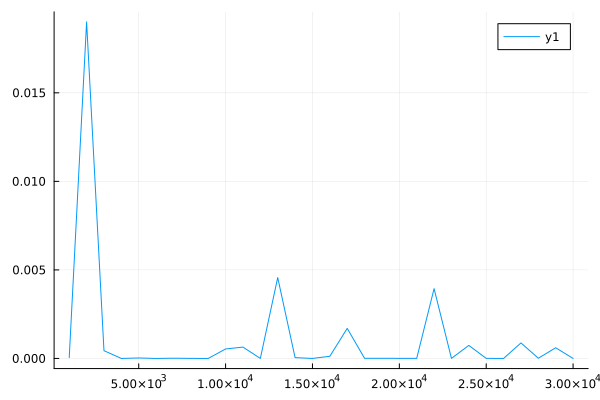

In [25]:
# plot MSE against steps
plot(steps, avg_MSD)